# Notebook 04 - Optimisation de la Marge (Partie 2)

## Projet : Detection de Fraudes - Transactions par Cheque

**M2 SISE - Fouille de Donnees Massives**

---

### Objectif de cette partie

Maximiser la **marge du commercant** en utilisant une matrice de couts asymetrique.



## 1. Configuration et imports

In [1]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
from datetime import datetime
import joblib

# Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Gradient Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Imports reussis")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Imports reussis
Date: 2026-01-07 19:29


In [5]:
# Import des modules du projet
import sys
sys.path.append('..')

from config.config import (
    PROCESSED_DATA_DIR, FIGURES_DIR, MODELS_DIR,
    RANDOM_STATE, TARGET_COLUMN
)


print(f"Random state: {RANDOM_STATE}")

Random state: 42


## 2. Fonctions de calcul de la marge

In [ ]:
def compute_fn_loss(montant):
    """
    Calcule la perte pour un Faux Negatif (fraude manquee) selon le montant.
    """
    if montant <= 20:
        return 0
    elif montant <= 50:
        return 0.2 * montant
    elif montant <= 100:
        return 0.3 * montant
    elif montant <= 200:
        return 0.5 * montant
    else:
        return 0.8 * montant

def compute_transaction_margin(y_true, y_pred, montant):
    """
    Calcule la marge pour une transaction individuelle.
    
    Args:
        y_true: Vraie etiquette (0=Normal, 1=Fraude)
        y_pred: Prediction (0=Normal, 1=Fraude)
        montant: Montant de la transaction
        
    Returns:
        Marge (positive = gain, negative = perte)
    """
    marge_base = 0.05 * montant  # 5% du montant
    
    if y_true == 0 and y_pred == 0:  # TN - Vrai Negatif
        return marge_base  # Gain de la marge
    
    elif y_true == 0 and y_pred == 1:  # FP - Faux Positif
        return -0.70 * marge_base  # Perte de 70% de la marge (manque a gagner)
    
    elif y_true == 1 and y_pred == 0:  # FN - Faux Negatif (fraude manquee)
        return -compute_fn_loss(montant)  # Perte selon le montant
    
    else:  # TP - Vrai Positif (fraude detectee)
        return 0  # Ni gain ni perte

def compute_total_margin(y_true, y_pred, montants):
    """
    Calcule la marge totale pour un ensemble de predictions.
    
    Args:
        y_true: Array des vraies etiquettes
        y_pred: Array des predictions
        montants: Array des montants
        
    Returns:
        Dictionnaire avec les details de la marge
    """
    total_margin = 0
    tn_gain = 0
    fp_loss = 0
    fn_loss = 0
    tp_count = 0
    
    tn_count = 0
    fp_count = 0
    fn_count = 0
    
    for yt, yp, m in zip(y_true, y_pred, montants):
        margin = compute_transaction_margin(yt, yp, m)
        total_margin += margin
        
        if yt == 0 and yp == 0:  # TN
            tn_gain += margin
            tn_count += 1
        elif yt == 0 and yp == 1:  # FP
            fp_loss += margin
            fp_count += 1
        elif yt == 1 and yp == 0:  # FN
            fn_loss += margin
            fn_count += 1
        else:  # TP
            tp_count += 1
    
    return {
        'total_margin': total_margin,
        'tn_gain': tn_gain,
        'fp_loss': fp_loss,
        'fn_loss': fn_loss,
        'tn_count': tn_count,
        'fp_count': fp_count,
        'fn_count': fn_count,
        'tp_count': tp_count
    }

def print_margin_details(margin_dict, model_name="Modele"):
    """
    Affiche les details de la marge.
    """
    print(f"\n{'='*70}")
    print(f"MARGE - {model_name}")
    print('='*70)
    
    print(f"\n[Decomposition]")
    print(f"   TN ({margin_dict['tn_count']:,} transactions): +{margin_dict['tn_gain']:,.2f} EUR")
    print(f"   FP ({margin_dict['fp_count']:,} transactions): {margin_dict['fp_loss']:,.2f} EUR")
    print(f"   FN ({margin_dict['fn_count']:,} transactions): {margin_dict['fn_loss']:,.2f} EUR")
    print(f"   TP ({margin_dict['tp_count']:,} transactions): 0.00 EUR")
    
    print(f"\n[MARGE TOTALE]")
    print(f"   {margin_dict['total_margin']:,.2f} EUR")
    
    print('='*70)

     

## 3. Chargement des donnees

In [7]:
# Charger les donnees preprocessees
X_train = pd.read_pickle(PROCESSED_DATA_DIR / 'X_train.pkl')
X_test = pd.read_pickle(PROCESSED_DATA_DIR / 'X_test.pkl')
y_train = pd.read_pickle(PROCESSED_DATA_DIR / 'y_train.pkl')
y_test = pd.read_pickle(PROCESSED_DATA_DIR / 'y_test.pkl')

# Recuperer les montants pour le calcul de la marge
montants_test = X_test['Montant'].values

print("Donnees chargees:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_train: {y_train.shape} - Taux fraude: {y_train.mean()*100:.2f}%")
print(f"   y_test:  {y_test.shape} - Taux fraude: {y_test.mean()*100:.2f}%")
print(f"\nMontant moyen (test): {montants_test.mean():.2f} EUR")
print(f"Montant total (test): {montants_test.sum():,.2f} EUR")

Donnees chargees:
   X_train: (3899362, 18)
   X_test:  (747411, 18)
   y_train: (3899362,) - Taux fraude: 0.60%
   y_test:  (747411,) - Taux fraude: 0.88%

Montant moyen (test): 62.28 EUR
Montant total (test): 46,551,435.92 EUR


In [8]:
# Dictionnaire pour stocker tous les resultats
all_margin_results = {}

## 4. Calcul de la marge de reference (sans modele)

Si on accepte toutes les transactions (pas de detection de fraude):

In [9]:
# Reference: accepter toutes les transactions (predire 0 pour tout)
y_pred_all_accept = np.zeros(len(y_test), dtype=int)

margin_reference = compute_total_margin(y_test.values, y_pred_all_accept, montants_test)
print_margin_details(margin_reference, "Reference (tout accepter)")

all_margin_results['0. Reference (tout accepter)'] = margin_reference


MARGE - Reference (tout accepter)

[Decomposition]
   TN (740,838 transactions): +2,294,459.36 EUR
   FP (0 transactions): 0.00 EUR
   FN (6,573 transactions): -352,607.67 EUR
   TP (0 transactions): 0.00 EUR

[MARGE TOTALE]
   1,941,851.69 EUR


In [10]:
# Reference 2: rejeter toutes les transactions (predire 1 pour tout)
y_pred_all_reject = np.ones(len(y_test), dtype=int)

margin_all_reject = compute_total_margin(y_test.values, y_pred_all_reject, montants_test)
print_margin_details(margin_all_reject, "Reference (tout rejeter)")


MARGE - Reference (tout rejeter)

[Decomposition]
   TN (0 transactions): +0.00 EUR
   FP (740,838 transactions): -1,606,121.55 EUR
   FN (0 transactions): 0.00 EUR
   TP (6,573 transactions): 0.00 EUR

[MARGE TOTALE]
   -1,606,121.55 EUR


## 5. METHODE 1: Meilleur modele de la Partie 1 (LightGBM + ADASYN)

In [12]:
print("="*70)
print("METHODE 1: LightGBM + ADASYN (meilleur F1 de la Partie 1)")
print("="*70)

# Application de ADASYN
print("\nApplication de ADASYN...")
adasyn = ADASYN(sampling_strategy=0.5, random_state=RANDOM_STATE)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Entrainement
print("Entrainement LightGBM...")
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)
lgbm_model.fit(X_train_adasyn, y_train_adasyn)

# Predictions avec seuil par defaut
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Calcul de la marge
margin_lgbm = compute_total_margin(y_test.values, y_pred_lgbm, montants_test)
print_margin_details(margin_lgbm, "LightGBM + ADASYN (seuil 0.5)")

all_margin_results['1. LightGBM + ADASYN'] = margin_lgbm

METHODE 1: LightGBM + ADASYN (meilleur F1 de la Partie 1)

Application de ADASYN...
Entrainement LightGBM...

MARGE - LightGBM + ADASYN (seuil 0.5)

[Decomposition]
   TN (692,795 transactions): +1,994,040.71 EUR
   FP (48,043 transactions): -210,293.06 EUR
   FN (4,636 transactions): -141,820.65 EUR
   TP (1,937 transactions): 0.00 EUR

[MARGE TOTALE]
   1,641,927.01 EUR


In [13]:
# Nettoyage memoire
del X_train_adasyn, y_train_adasyn
import gc
gc.collect()

1202

## 6. Optimisation du seuil pour maximiser la marge

In [14]:
def find_best_threshold_for_margin(y_true, y_proba, montants):
    """
    Trouve le seuil optimal pour maximiser la marge.
    """
    thresholds = np.arange(0.01, 0.99, 0.01)
    margins = []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        margin = compute_total_margin(y_true, y_pred, montants)
        margins.append(margin['total_margin'])
    
    best_idx = np.argmax(margins)
    best_threshold = thresholds[best_idx]
    best_margin = margins[best_idx]
    
    return best_threshold, best_margin, thresholds, margins

Seuil optimal pour la marge: 0.77
Marge maximale: 1,988,509.38 EUR


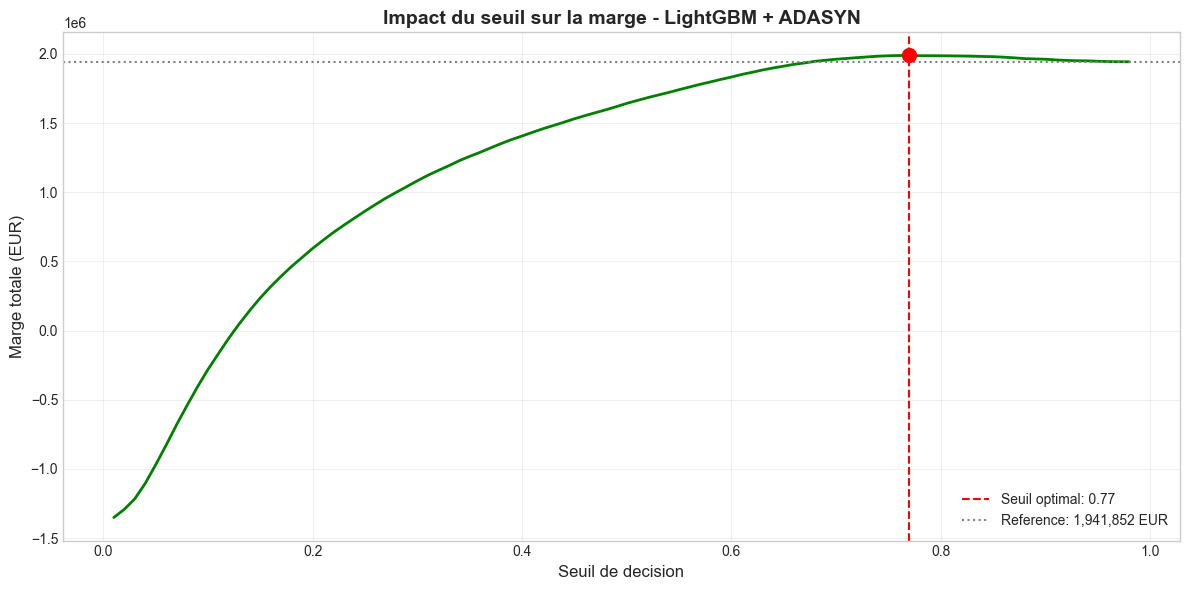

In [15]:
# Trouver le seuil optimal pour LightGBM
best_thresh_lgbm, best_margin_lgbm, thresholds, margins_lgbm = find_best_threshold_for_margin(
    y_test.values, y_proba_lgbm, montants_test
)

print(f"Seuil optimal pour la marge: {best_thresh_lgbm:.2f}")
print(f"Marge maximale: {best_margin_lgbm:,.2f} EUR")

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(thresholds, margins_lgbm, linewidth=2, color='green')
plt.axvline(x=best_thresh_lgbm, color='red', linestyle='--', label=f'Seuil optimal: {best_thresh_lgbm:.2f}')
plt.axhline(y=margin_reference['total_margin'], color='gray', linestyle=':', label=f'Reference: {margin_reference["total_margin"]:,.0f} EUR')
plt.scatter([best_thresh_lgbm], [best_margin_lgbm], color='red', s=100, zorder=5)
plt.xlabel('Seuil de decision', fontsize=12)
plt.ylabel('Marge totale (EUR)', fontsize=12)
plt.title('Impact du seuil sur la marge - LightGBM + ADASYN', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'threshold_margin_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Evaluation avec le seuil optimise
y_pred_lgbm_opt = (y_proba_lgbm >= best_thresh_lgbm).astype(int)
margin_lgbm_opt = compute_total_margin(y_test.values, y_pred_lgbm_opt, montants_test)
print_margin_details(margin_lgbm_opt, f"LightGBM + ADASYN (seuil {best_thresh_lgbm:.2f})")

all_margin_results['1b. LightGBM + ADASYN (seuil opt)'] = margin_lgbm_opt


MARGE - LightGBM + ADASYN (seuil 0.77)

[Decomposition]
   TN (738,465 transactions): +2,273,071.79 EUR
   FP (2,373 transactions): -14,971.30 EUR
   FN (6,085 transactions): -269,591.11 EUR
   TP (488 transactions): 0.00 EUR

[MARGE TOTALE]
   1,988,509.38 EUR


## 7. METHODE 2: XGBoost avec poids de classe personnalises

In [17]:
print("="*70)
print("METHODE 2: XGBoost avec scale_pos_weight eleve")
print("="*70)

# Utiliser un poids plus eleve pour penaliser les FN
# On teste plusieurs valeurs
scale_weights = [50, 100, 150, 200, 300]
best_xgb_margin = -np.inf
best_xgb_weight = None
best_xgb_proba = None

for weight in scale_weights:
    print(f"\nTest scale_pos_weight = {weight}...")
    
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=weight,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0
    )
    xgb_model.fit(X_train, y_train)
    
    y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    
    # Trouver le meilleur seuil pour ce modele
    thresh, margin, _, _ = find_best_threshold_for_margin(y_test.values, y_proba_xgb, montants_test)
    print(f"   Meilleur seuil: {thresh:.2f}, Marge: {margin:,.2f} EUR")
    
    if margin > best_xgb_margin:
        best_xgb_margin = margin
        best_xgb_weight = weight
        best_xgb_proba = y_proba_xgb
        best_xgb_thresh = thresh

print(f"\nMeilleur scale_pos_weight: {best_xgb_weight}")
print(f"Marge maximale: {best_xgb_margin:,.2f} EUR")

METHODE 2: XGBoost avec scale_pos_weight eleve

Test scale_pos_weight = 50...
   Meilleur seuil: 0.87, Marge: 2,010,032.53 EUR

Test scale_pos_weight = 100...
   Meilleur seuil: 0.93, Marge: 2,004,770.28 EUR

Test scale_pos_weight = 150...
   Meilleur seuil: 0.96, Marge: 2,005,495.72 EUR

Test scale_pos_weight = 200...
   Meilleur seuil: 0.96, Marge: 2,005,435.20 EUR

Test scale_pos_weight = 300...
   Meilleur seuil: 0.97, Marge: 2,005,486.76 EUR

Meilleur scale_pos_weight: 50
Marge maximale: 2,010,032.53 EUR


In [18]:
# Evaluation avec le meilleur XGBoost
y_pred_xgb_opt = (best_xgb_proba >= best_xgb_thresh).astype(int)
margin_xgb_opt = compute_total_margin(y_test.values, y_pred_xgb_opt, montants_test)
print_margin_details(margin_xgb_opt, f"XGBoost (weight={best_xgb_weight}, seuil={best_xgb_thresh:.2f})")

all_margin_results['2. XGBoost optimise'] = margin_xgb_opt


MARGE - XGBoost (weight=50, seuil=0.87)

[Decomposition]
   TN (738,947 transactions): +2,269,681.23 EUR
   FP (1,891 transactions): -17,344.69 EUR
   FN (5,945 transactions): -242,304.02 EUR
   TP (628 transactions): 0.00 EUR

[MARGE TOTALE]
   2,010,032.53 EUR


## 8. METHODE 3: Random Forest + SMOTE avec seuil optimise

In [20]:
print("="*70)
print("METHODE 3: Random Forest + SMOTE avec seuil optimise")
print("="*70)

# Application de SMOTE
print("\nApplication de SMOTE...")
smote = SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Entrainement
print("Entrainement Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_model.fit(X_train_smote, y_train_smote)

# Predictions
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Trouver le seuil optimal
best_thresh_rf, best_margin_rf, _, _ = find_best_threshold_for_margin(
    y_test.values, y_proba_rf, montants_test
)

print(f"\nSeuil optimal: {best_thresh_rf:.2f}")
print(f"Marge maximale: {best_margin_rf:,.2f} EUR")

# Evaluation
y_pred_rf_opt = (y_proba_rf >= best_thresh_rf).astype(int)
margin_rf_opt = compute_total_margin(y_test.values, y_pred_rf_opt, montants_test)
print_margin_details(margin_rf_opt, f"RF + SMOTE (seuil {best_thresh_rf:.2f})")

all_margin_results['3. RF + SMOTE optimise'] = margin_rf_opt

METHODE 3: Random Forest + SMOTE avec seuil optimise

Application de SMOTE...
Entrainement Random Forest...

Seuil optimal: 0.91
Marge maximale: 1,978,646.20 EUR

MARGE - RF + SMOTE (seuil 0.91)

[Decomposition]
   TN (740,513 transactions): +2,289,692.69 EUR
   FP (325 transactions): -3,336.67 EUR
   FN (6,394 transactions): -307,709.82 EUR
   TP (179 transactions): 0.00 EUR

[MARGE TOTALE]
   1,978,646.20 EUR


In [21]:
# Nettoyage memoire
del X_train_smote, y_train_smote
gc.collect()

4345

## 9. METHODE 4: Strategie basee sur le montant

Idee: Adapter le seuil selon le montant de la transaction (plus strict pour les gros montants)

In [22]:
print("="*70)
print("METHODE 4: Strategie avec seuil adaptatif selon le montant")
print("="*70)

def predict_with_adaptive_threshold(y_proba, montants, thresholds_by_amount):
    """
    Applique des seuils differents selon le montant.
    
    thresholds_by_amount: dict avec les seuils par tranche de montant
    """
    y_pred = np.zeros(len(y_proba), dtype=int)
    
    for i, (prob, m) in enumerate(zip(y_proba, montants)):
        if m <= 20:
            thresh = thresholds_by_amount.get('<=20', 0.5)
        elif m <= 50:
            thresh = thresholds_by_amount.get('20-50', 0.5)
        elif m <= 100:
            thresh = thresholds_by_amount.get('50-100', 0.5)
        elif m <= 200:
            thresh = thresholds_by_amount.get('100-200', 0.5)
        else:
            thresh = thresholds_by_amount.get('>200', 0.5)
        
        y_pred[i] = 1 if prob >= thresh else 0
    
    return y_pred

# Tester differentes configurations de seuils adaptatifs
# Logique: plus le montant est eleve, plus on est strict (seuil bas)
adaptive_configs = [
    {'<=20': 0.9, '20-50': 0.7, '50-100': 0.5, '100-200': 0.3, '>200': 0.2},
    {'<=20': 0.95, '20-50': 0.8, '50-100': 0.6, '100-200': 0.4, '>200': 0.25},
    {'<=20': 0.99, '20-50': 0.9, '50-100': 0.7, '100-200': 0.5, '>200': 0.3},
]

best_adaptive_margin = -np.inf
best_adaptive_config = None

for config in adaptive_configs:
    y_pred_adaptive = predict_with_adaptive_threshold(y_proba_lgbm, montants_test, config)
    margin = compute_total_margin(y_test.values, y_pred_adaptive, montants_test)
    print(f"Config {config}")
    print(f"   Marge: {margin['total_margin']:,.2f} EUR")
    
    if margin['total_margin'] > best_adaptive_margin:
        best_adaptive_margin = margin['total_margin']
        best_adaptive_config = config
        best_adaptive_result = margin

print(f"\nMeilleure configuration adaptative:")
print(f"   {best_adaptive_config}")
print_margin_details(best_adaptive_result, "Seuil adaptatif")

all_margin_results['4. Seuil adaptatif'] = best_adaptive_result

METHODE 4: Strategie avec seuil adaptatif selon le montant
Config {'<=20': 0.9, '20-50': 0.7, '50-100': 0.5, '100-200': 0.3, '>200': 0.2}
   Marge: 1,270,486.94 EUR
Config {'<=20': 0.95, '20-50': 0.8, '50-100': 0.6, '100-200': 0.4, '>200': 0.25}
   Marge: 1,492,000.07 EUR
Config {'<=20': 0.99, '20-50': 0.9, '50-100': 0.7, '100-200': 0.5, '>200': 0.3}
   Marge: 1,665,460.62 EUR

Meilleure configuration adaptative:
   {'<=20': 0.99, '20-50': 0.9, '50-100': 0.7, '100-200': 0.5, '>200': 0.3}

MARGE - Seuil adaptatif

[Decomposition]
   TN (711,897 transactions): +2,000,922.51 EUR
   FP (28,941 transactions): -205,475.80 EUR
   FN (5,224 transactions): -129,986.09 EUR
   TP (1,349 transactions): 0.00 EUR

[MARGE TOTALE]
   1,665,460.62 EUR


## 10. METHODE 5: Ensemble de modeles

In [23]:
print("="*70)
print("METHODE 5: Ensemble (moyenne des probabilites)")
print("="*70)

# Moyenne des probabilites des meilleurs modeles
y_proba_ensemble = (y_proba_lgbm + best_xgb_proba + y_proba_rf) / 3

# Trouver le seuil optimal
best_thresh_ensemble, best_margin_ensemble, _, _ = find_best_threshold_for_margin(
    y_test.values, y_proba_ensemble, montants_test
)

print(f"Seuil optimal: {best_thresh_ensemble:.2f}")
print(f"Marge maximale: {best_margin_ensemble:,.2f} EUR")

# Evaluation
y_pred_ensemble = (y_proba_ensemble >= best_thresh_ensemble).astype(int)
margin_ensemble = compute_total_margin(y_test.values, y_pred_ensemble, montants_test)
print_margin_details(margin_ensemble, f"Ensemble (seuil {best_thresh_ensemble:.2f})")

all_margin_results['5. Ensemble'] = margin_ensemble

METHODE 5: Ensemble (moyenne des probabilites)
Seuil optimal: 0.82
Marge maximale: 1,998,132.50 EUR

MARGE - Ensemble (seuil 0.82)

[Decomposition]
   TN (739,562 transactions): +2,277,594.28 EUR
   FP (1,276 transactions): -11,805.56 EUR
   FN (6,133 transactions): -267,656.22 EUR
   TP (440 transactions): 0.00 EUR

[MARGE TOTALE]
   1,998,132.50 EUR


## 11. Comparaison des methodes

In [24]:
# Tableau comparatif
print("\n" + "="*80)
print("COMPARAISON DES MARGES")
print("="*80)

comparison_data = []
for name, result in all_margin_results.items():
    comparison_data.append({
        'Methode': name,
        'Marge Totale (EUR)': result['total_margin'],
        'Gain TN (EUR)': result['tn_gain'],
        'Perte FP (EUR)': result['fp_loss'],
        'Perte FN (EUR)': result['fn_loss'],
        'TP': result['tp_count'],
        'FN': result['fn_count']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Marge Totale (EUR)', ascending=False)
print("\n")
print(comparison_df.to_string(index=False))


COMPARAISON DES MARGES


                          Methode  Marge Totale (EUR)  Gain TN (EUR)  Perte FP (EUR)  Perte FN (EUR)   TP   FN
              2. XGBoost optimise        2.010033e+06   2269681.2345    -17344.69030     -242304.018  628 5945
                      5. Ensemble        1.998133e+06   2277594.2835    -11805.55600     -267656.223  440 6133
1b. LightGBM + ADASYN (seuil opt)        1.988509e+06   2273071.7875    -14971.30320     -269591.109  488 6085
           3. RF + SMOTE optimise        1.978646e+06   2289692.6930     -3336.66935     -307709.821  179 6394
     0. Reference (tout accepter)        1.941852e+06   2294459.3635         0.00000     -352607.669    0 6573
               4. Seuil adaptatif        1.665461e+06   2000922.5060   -205475.80025     -129986.089 1349 5224
             1. LightGBM + ADASYN        1.641927e+06   1994040.7120   -210293.05605     -141820.646 1937 4636


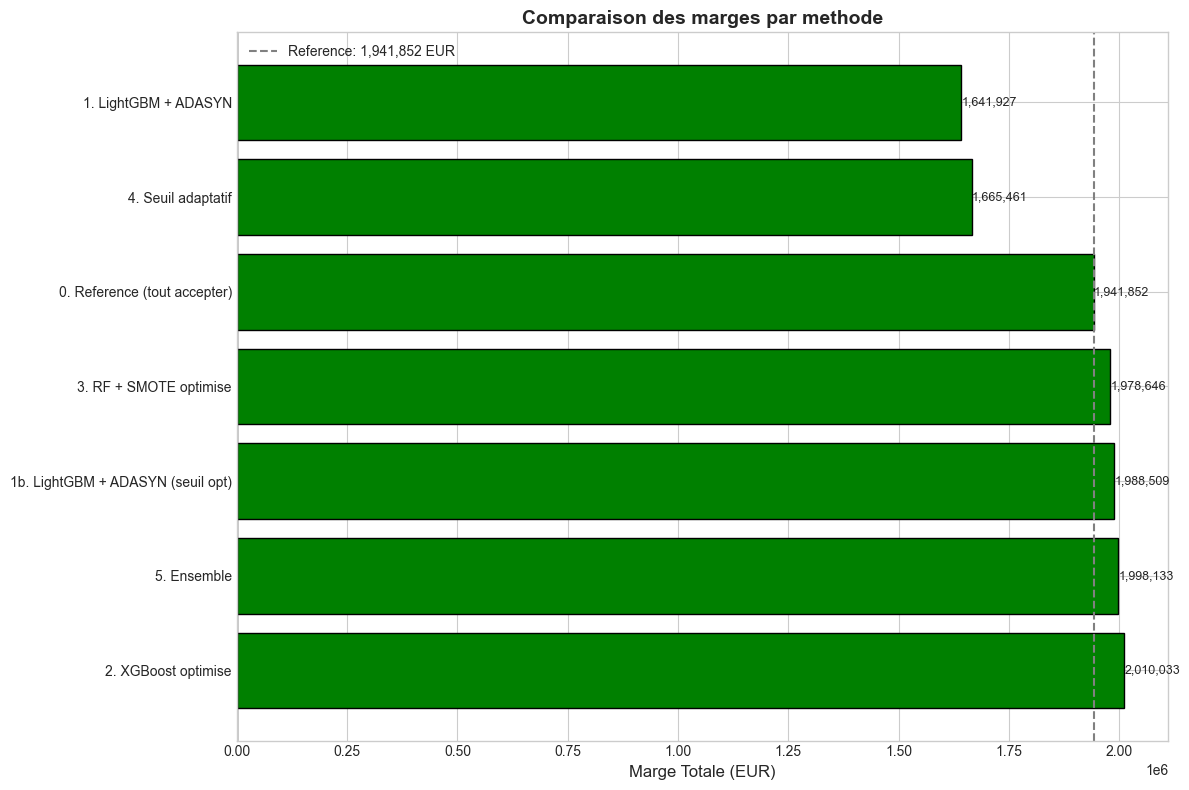

In [25]:
# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))

methods = comparison_df['Methode'].values
margins = comparison_df['Marge Totale (EUR)'].values

colors = ['green' if m > 0 else 'red' for m in margins]
bars = ax.barh(methods, margins, color=colors, edgecolor='black')

ax.axvline(x=0, color='black', linewidth=1)
ax.axvline(x=margin_reference['total_margin'], color='gray', linestyle='--', 
           label=f'Reference: {margin_reference["total_margin"]:,.0f} EUR')

ax.set_xlabel('Marge Totale (EUR)', fontsize=12)
ax.set_title('Comparaison des marges par methode', fontsize=14, fontweight='bold')
ax.legend()

# Ajouter les valeurs
for bar, margin in zip(bars, margins):
    x_pos = margin + 1000 if margin >= 0 else margin - 15000
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{margin:,.0f}', 
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'margin_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Analyse du meilleur modele

In [26]:
# Identifier le meilleur modele
best_method = comparison_df.iloc[0]['Methode']
best_margin_total = comparison_df.iloc[0]['Marge Totale (EUR)']

print(f"\nMEILLEUR MODELE POUR LA MARGE: {best_method}")
print(f"Marge totale: {best_margin_total:,.2f} EUR")
print(f"\nAmelioration par rapport a la reference:")
improvement = best_margin_total - margin_reference['total_margin']
improvement_pct = (improvement / abs(margin_reference['total_margin'])) * 100
print(f"   {improvement:+,.2f} EUR ({improvement_pct:+.1f}%)")


MEILLEUR MODELE POUR LA MARGE: 2. XGBoost optimise
Marge totale: 2,010,032.53 EUR

Amelioration par rapport a la reference:
   +68,180.83 EUR (+3.5%)


## 13. Resume final

In [27]:
print("\n" + "="*80)
print("RESUME FINAL - PARTIE 2 (Optimisation de la Marge)")
print("="*80)

print(f"\n[CONTEXTE]")
print(f"   Transactions test: {len(y_test):,}")
print(f"   Montant total: {montants_test.sum():,.2f} EUR")
print(f"   Fraudes: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")

print(f"\n[REFERENCE - Sans detection]")
print(f"   Marge si tout accepter: {margin_reference['total_margin']:,.2f} EUR")

print(f"\n[METHODES TESTEES]")
for _, row in comparison_df.iterrows():
    print(f"   {row['Methode']}: {row['Marge Totale (EUR)']:,.2f} EUR")

print(f"\n[MEILLEUR RESULTAT]")
print(f"   Methode: {best_method}")
print(f"   Marge: {best_margin_total:,.2f} EUR")
print(f"   Amelioration vs reference: {improvement:+,.2f} EUR ({improvement_pct:+.1f}%)")

print(f"\n[CONCLUSION]")
if best_margin_total > margin_reference['total_margin']:
    print(f"   Le systeme de detection de fraude AMELIORE la marge du commercant.")
else:
    print(f"   Le systeme de detection ne permet pas d'ameliorer la marge.")
    print(f"   Il vaut mieux accepter toutes les transactions.")

print("\n" + "="*80)


RESUME FINAL - PARTIE 2 (Optimisation de la Marge)

[CONTEXTE]
   Transactions test: 747,411
   Montant total: 46,551,435.92 EUR
   Fraudes: 6,573 (0.88%)

[REFERENCE - Sans detection]
   Marge si tout accepter: 1,941,851.69 EUR

[METHODES TESTEES]
   2. XGBoost optimise: 2,010,032.53 EUR
   5. Ensemble: 1,998,132.50 EUR
   1b. LightGBM + ADASYN (seuil opt): 1,988,509.38 EUR
   3. RF + SMOTE optimise: 1,978,646.20 EUR
   0. Reference (tout accepter): 1,941,851.69 EUR
   4. Seuil adaptatif: 1,665,460.62 EUR
   1. LightGBM + ADASYN: 1,641,927.01 EUR

[MEILLEUR RESULTAT]
   Methode: 2. XGBoost optimise
   Marge: 2,010,032.53 EUR
   Amelioration vs reference: +68,180.83 EUR (+3.5%)

[CONCLUSION]
   Le systeme de detection de fraude AMELIORE la marge du commercant.



## 14. Sauvegarde des resultats

In [28]:
# Sauvegarder les resultats
comparison_df.to_csv(MODELS_DIR / 'margin_comparison_results.csv', index=False)
print(f"Resultats sauvegardes: {MODELS_DIR / 'margin_comparison_results.csv'}")

Resultats sauvegardes: c:\Users\HP\Desktop\Master2\fouille_de_donnee\projet_Fouilles_de_Données_Massives\notebooks\..\models\margin_comparison_results.csv
